In [96]:
#IMPORT LIBRARIES
!pip install sportsreference
from sportsreference.nba.schedule import Schedule
from datetime import datetime
from sportsreference.nba.boxscore import Boxscores, Boxscore
from sportsreference.nba.teams import Teams
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score

In [3]:
#Declare Useful Functions and Lists
def format_nba_df(df):
  ## create a bool column for home win
  df['homeWin'] = df['winner'] == 'Home'
  ## rename unnamed column to gameid
  df = df.rename(columns={'Unnamed: 0': 'gameID'})
  ## create datetime object from column of date strings and drop the time 
  df['date'] = df['date'].apply(lambda x: (datetime.strptime(x, '%I:%M %p, %B %d, %Y')).date())
  ## create home team column
  df['homeTeam'] = np.where(df['homeWin']==True, df['winning_abbr'], df['losing_abbr'])
  ## create away team column
  df['awayTeam'] = np.where(df['homeWin']==False, df['winning_abbr'], df['losing_abbr'])
  return df

In [4]:
## this takes an odds dataframe and converts the date to a datetime object, year must be specified
def convert_to_datetime(x, year):
  y = str(x)
  if x < 1000:
    date = datetime(year=year, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")
  else:
    date = datetime(year=year-1, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")

In [5]:
def avg_previous_num_games(df, num_games):
  ### This function changes each stat to be the average of the last num_games for each team, and shifts it one so it does not include the current stats and drops the first num_games that become null
  for col in home_cols:
    for team in team_list:
      df[col].loc[df['homeTeam']==team] = df[col].loc[df['homeTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  for col in away_cols:
    for team in team_list:
      df[col].loc[df['awayTeam']==team] = df[col].loc[df['awayTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  return df.dropna()

In [6]:
# seperate statistical columns to home and away for later
away_cols = ['away_assist_percentage', 'away_assists',
       'away_block_percentage', 'away_blocks', 'away_defensive_rating',
       'away_defensive_rebound_percentage', 'away_defensive_rebounds',
       'away_effective_field_goal_percentage', 'away_field_goal_attempts',
       'away_field_goal_percentage', 'away_field_goals',
       'away_free_throw_attempt_rate', 'away_free_throw_attempts',
       'away_free_throw_percentage', 'away_free_throws','away_minutes_played', 'away_offensive_rating',
       'away_offensive_rebound_percentage', 'away_offensive_rebounds',
       'away_personal_fouls', 'away_points', 'away_steal_percentage',
       'away_steals', 'away_three_point_attempt_rate',
       'away_three_point_field_goal_attempts',
       'away_three_point_field_goal_percentage',
       'away_three_point_field_goals', 'away_total_rebound_percentage',
       'away_total_rebounds', 'away_true_shooting_percentage',
       'away_turnover_percentage', 'away_turnovers',
       'away_two_point_field_goal_attempts',
       'away_two_point_field_goal_percentage', 'away_two_point_field_goals']
home_cols = ['home_assist_percentage', 'home_assists',
       'home_block_percentage', 'home_blocks', 'home_defensive_rating',
       'home_defensive_rebound_percentage', 'home_defensive_rebounds',
       'home_effective_field_goal_percentage', 'home_field_goal_attempts',
       'home_field_goal_percentage', 'home_field_goals',
       'home_free_throw_attempt_rate', 'home_free_throw_attempts',
       'home_free_throw_percentage', 'home_free_throws',
       'home_minutes_played', 'home_offensive_rating',
       'home_offensive_rebound_percentage', 'home_offensive_rebounds',
       'home_personal_fouls', 'home_points', 'home_steal_percentage',
       'home_steals', 'home_three_point_attempt_rate',
       'home_three_point_field_goal_attempts',
       'home_three_point_field_goal_percentage',
       'home_three_point_field_goals', 'home_total_rebound_percentage',
       'home_total_rebounds', 'home_true_shooting_percentage',
       'home_turnover_percentage', 'home_turnovers',
       'home_two_point_field_goal_attempts',
       'home_two_point_field_goal_percentage', 'home_two_point_field_goals']

In [7]:
import pandas as pd
nba2017 = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba2017-18.csv")
# load 2018-19 boxscore stats
nba2018 = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba2018-19.csv")
# load 2019-20 boxscore stats
nbaCurrent = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba2019-20.csv")

In [8]:
# apply cleaning step
nba2017 = format_nba_df(nba2017)
nba2018 = format_nba_df(nba2018)
nbaCurrent = format_nba_df(nbaCurrent)

In [9]:
nba2017.head(5)

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
0,201710170CLE,66.7,24,6.6,4,102.7,80.4,37,0.455,88,0.409,36,0.284,25,0.760,19,1,240,99.7,18.0,9,24,99,11.1,11,0.364,32,0.250,8,47.9,46,0.500,9.2,10,56,0.500,28,0,2017-10-17,50.0,24,7.1,4,99.7,82.0,37,0.488,88,0.409,36,0.301,25,0.760,19,0,240,102.7,19.6,9,24,102,3.0,11,0.265,32,0.250,8,52.1,46,0.543,15.3,10,56,0.500,28,1,"Quicken Loans Arena, Cleveland, Ohio",BOS,Boston Celtics,99.3,Home,CLE,Cleveland Cavaliers,True,CLE,BOS
1,201710170GSW,59.6,28,10.0,5,118.6,84.6,33,0.562,97,0.485,47,0.196,19,0.684,13,0,240,119.6,22.2,10,16,122,8.8,9,0.423,41,0.366,15,51.2,43,0.579,10.2,12,56,0.571,32,1,2017-10-17,79.1,28,16.1,5,119.6,77.8,33,0.638,97,0.485,47,0.263,19,0.684,13,1,240,118.6,15.4,10,16,121,4.9,9,0.375,41,0.366,15,48.8,43,0.678,16.0,12,56,0.571,32,0,"Oracle Arena, Oakland, California",GSW,Golden State Warriors,102.0,Away,HOU,Houston Rockets,False,GSW,HOU
2,201710180BOS,50.0,19,6.3,4,102.2,78.0,39,0.546,76,0.500,38,0.395,30,0.833,25,0,240,110.4,15.8,6,22,108,6.1,6,0.276,21,0.333,7,51.1,45,0.605,14.4,15,55,0.564,31,1,2017-10-18,59.0,19,3.6,4,110.4,84.2,39,0.489,76,0.500,38,0.231,30,0.833,25,2,240,102.2,22.0,6,22,100,12.3,6,0.308,21,0.333,7,48.9,45,0.499,10.7,15,55,0.564,31,0,"TD Garden, Boston, Massachusetts",BOS,Boston Celtics,97.9,Away,MIL,Milwaukee Bucks,False,BOS,MIL
3,201710180DAL,41.7,20,14.6,6,112.6,80.0,36,0.559,94,0.511,48,0.160,15,0.800,12,0,240,118.7,30.4,14,18,117,11.2,11,0.191,18,0.500,9,54.9,50,0.582,11.4,13,76,0.513,39,1,2017-10-18,71.1,20,5.3,6,118.7,69.6,36,0.541,94,0.511,48,0.244,15,0.800,12,1,240,112.6,20.0,14,18,111,5.1,11,0.523,18,0.500,9,45.1,50,0.583,13.6,13,76,0.513,39,0,"American Airlines Center, Dallas, Texas",DAL,Dallas Mavericks,98.6,Away,ATL,Atlanta Hawks,False,DAL,ATL
4,201710180DET,55.2,16,4.3,3,103.6,83.0,44,0.459,73,0.397,29,0.397,29,0.793,23,1,240,91.4,7.3,3,15,90,4.1,4,0.411,30,0.300,9,50.0,47,0.525,16.5,17,43,0.465,20,0,2017-10-18,58.5,16,7.0,3,91.4,92.7,44,0.474,73,0.397,29,0.125,29,0.793,23,0,240,103.6,17.0,3,15,102,14.2,4,0.271,30,0.300,9,50.0,47,0.504,7.3,17,43,0.465,20,1,"Little Caesars Arena, Detroit, Michigan",CHO,Charlotte

In [10]:
nba2018.head(5)

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
0,201810160BOS,52.9,18,8.3,5,100.7,77.4,41,0.420,87,0.391,34,0.264,23,0.609,14,0,240,83.4,12.2,6,20,87,7.7,8,0.299,26,0.192,5,46.1,47,0.448,14.1,16,61,0.475,29,0,2018-10-16,50.0,18,8.2,5,83.4,87.8,41,0.490,87,0.391,34,0.144,23,0.609,14,0,240,100.7,22.6,6,20,105,6.7,8,0.381,26,0.192,5,53.9,47,0.509,11.9,16,61,0.475,29,1,"TD Garden, Boston, Massachusetts",PHI,Philadelphia 76ers,104.3,Home,BOS,Boston Celtics,True,BOS,PHI
1,201810160GSW,63.6,21,8.7,6,105.6,63.0,29,0.418,91,0.363,33,0.407,37,0.649,24,1,240,97.7,28.1,16,21,100,11.7,12,0.407,37,0.270,10,43.7,45,0.466,11.5,14,54,0.426,23,0,2018-10-16,66.7,21,13.0,6,97.7,71.9,29,0.479,91,0.363,33,0.189,37,0.649,24,0,240,105.6,37.0,16,21,108,6.8,12,0.274,37,0.270,10,56.3,45,0.525,16.9,14,54,0.426,23,1,"Oracle Arena, Oakland, California",OKC,Oklahoma City Thunder,102.3,Home,GSW,Golden State Warriors,True,GSW,OKC
2,201810170CHO,61.9,26,7.4,4,109.2,83.6,46,0.576,85,0.494,42,0.235,20,0.750,15,0,240,110.2,25.6,11,25,113,4.9,5,0.400,34,0.412,14,58.2,57,0.602,18.3,21,51,0.549,28,1,2018-10-17,51.2,26,17.6,4,110.2,74.4,46,0.533,85,0.494,42,0.239,20,0.750,15,1,240,109.2,16.4,11,25,112,7.8,5,0.413,34,0.412,14,41.8,57,0.551,9.8,21,51,0.549,28,0,"Spectrum Center, Charlotte, North Carolina",CHO,Charlotte Hornets,102.6,Away,MIL,Milwaukee Bucks,False,CHO,MIL
3,201810170DET,70.0,28,7.4,5,103.0,70.8,34,0.518,82,0.488,40,0.268,22,0.682,15,1,240,100.0,13.5,5,23,100,9.0,9,0.329,27,0.185,5,45.9,39,0.545,15.6,17,55,0.636,35,0,2018-10-17,53.8,28,9.1,5,100.0,86.5,34,0.457,82,0.488,40,0.239,22,0.682,15,0,240,103.0,29.2,5,23,103,5.0,9,0.261,27,0.185,5,54.1,39,0.506,12.1,17,55,0.636,35,1,"Little Caesars Arena, Detroit, Michigan",BRK,Brooklyn Nets,100.0,Home,DET,Detroit Pistons,True,DET,BRK
4,201810170HOU,69.2,36,6.8,3,108.8,83.3,40,0.582,98,0.531,52,0.224,22,0.773,17,0,240,127.2,32.6,14,25,131,7.8,8,0.255,25,0.400,10,59.3,54,0.608,10.0,12,73,0.575,42,1,2018-10-17,53.8,36,9.6,3,127.2,67.4,40,0.511,98,0.531,52,0.261,22,0.773,17,1,240,108.8,16.7,14,25,112,7.8,8,0.522,25,0.400,10,40.7,54,0.546,9.7,12,73,0.575,42,0,"Toyota Center, Houston, Texas",HOU,Hou

In [11]:
nbaCurrent.head(5)

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
0,201910220LAC,54.1,20,14.0,7,117.5,74.4,32,0.512,85,0.435,37,0.247,21,0.714,15,1,240,107.0,20.9,9,24,102,4.2,4,0.388,33,0.394,13,47.7,41,0.541,12.9,14,52,0.462,24,0,2019-10-22,57.1,20,9.6,7,107.0,79.1,32,0.586,85,0.435,37,0.296,21,0.714,15,0,240,117.5,25.6,9,24,112,8.4,4,0.383,33,0.394,13,52.3,41,0.612,13.3,14,52,0.462,24,0,"STAPLES Center, Los Angeles, California",LAL,Los Angeles Lakers,95.3,Home,LAC,Los Angeles Clippers,True,LAC,LAL
1,201910220TOR,69.8,30,14.3,9,115.2,69.8,37,0.515,102,0.422,43,0.196,20,0.850,17,1,265,108.1,28.1,16,34,122,3.5,4,0.441,45,0.422,19,48.2,53,0.551,14.6,19,57,0.421,24,0,2019-10-22,54.8,30,5.3,9,108.1,71.9,37,0.476,102,0.422,43,0.369,20,0.850,17,0,265,115.2,30.2,16,34,130,6.2,4,0.388,45,0.422,19,51.8,53,0.543,11.8,19,57,0.421,24,0,"Scotiabank Arena, Toronto, Canada",NOP,New Orleans Pelicans,102.2,Home,TOR,Toronto Raptors,True,TOR,NOP
2,201910230BRK,50.0,23,6.0,4,108.5,80.0,40,0.486,108,0.426,46,0.259,28,0.786,22,0,265,109.3,24.0,12,22,127,7.7,9,0.398,43,0.302,13,52.0,52,0.528,9.8,13,65,0.508,33,1,2019-10-23,39.6,23,13.8,4,109.3,76.0,40,0.550,108,0.426,46,0.257,28,0.786,22,0,265,108.5,20.0,12,22,126,6.9,9,0.337,43,0.302,13,48.0,52,0.560,12.5,13,65,0.508,33,0,"Barclays Center, Brooklyn, New York",BRK,Brooklyn Nets,105.2,Away,MIN,Minnesota Timberwolves,False,BRK,MIN
3,201910230CHO,51.0,25,9.1,4,124.0,76.3,29,0.510,105,0.467,49,0.210,22,0.818,18,1,240,123.0,38.5,20,20,125,10.8,11,0.286,30,0.300,9,54.4,49,0.545,8.0,10,75,0.533,40,0,2019-10-23,62.2,25,5.3,4,123.0,61.5,29,0.642,105,0.467,49,0.182,22,0.818,18,0,240,124.0,23.7,20,20,126,3.0,11,0.500,30,0.300,9,45.6,49,0.663,16.7,10,75,0.533,40,0,"Spectrum Center, Charlotte, North Carolina",CHI,Chicago Bulls,101.6,Home,CHO,Charlotte Hornets,True,CHO,CHI
4,201910230DAL,70.3,26,7.5,3,104.2,87.8,36,0.457,93,0.398,37,0.194,18,0.833,15,1,240,96.4,21.2,11,32,100,5.8,6,0.441,41,0.268,11,50.5,47,0.495,14.4,17,52,0.500,26,0,2019-10-23,48.6,26,9.6,3,96.4,78.8,36,0.533,93,0.398,37,0.434,18,0.833,15,0,240,104.2,12.2,11,32,108,5.8,6,0.474,41,0.268,11,49.5,47,0.597,17.3,17,52,0.500,26,0,"American Airlines 

In [12]:
# load 2017-18 odds
odds2017 = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba odds 2017-18.csv")
# load 2018-19 odds
odds2018 = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba odds 2018-19.csv")
# load 2019-20 odds
oddsCurrent = pd.read_csv("C:\\Users\\Admin\\Desktop\\FILES\\AKPROJECTS\\Nba-Sports-Betting-Model-master\\nba odds 2019-20.csv")

In [13]:
odds2017.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1017,501,V,Boston,19,19,33,28,99,214.5,216,166,1.5
1,1017,502,H,Cleveland,29,25,18,30,102,4,4.5,-195,110
2,1017,503,V,Houston,34,28,26,34,122,232,231.5,364,115.5
3,1017,504,H,GoldenState,35,36,30,20,121,9,9,-470,2.5
4,1018,701,V,Brooklyn,30,33,35,33,131,212,216.5,135,112.5


In [14]:
odds2018.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1016,501,V,Philadelphia,21,21,24,21,87,208.5,211.5,170,106
1,1016,502,H,Boston,21,26,30,28,105,5,4.5,-200,1
2,1016,503,V,OklahomaCity,23,24,32,21,100,223.5,220.5,711,108.5
3,1016,504,H,GoldenState,31,26,26,25,108,11.5,12,-1100,4.5
4,1017,701,V,Memphis,16,23,19,25,83,209,204.5,263,1


In [15]:
oddsCurrent.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1022,501,V,NewOrleans,30,31,25,31,122,231.5,229.5,230,113
1,1022,502,H,Toronto,27,29,32,29,130,6.5,6.5,-280,6
2,1022,503,V,LALakers,25,29,31,17,102,227,3.5,-180,5
3,1022,504,H,LAClippers,22,40,23,27,112,1.5,224,150,110.5
4,1023,505,V,Detroit,27,27,29,36,119,210,211,240,104


In [16]:
## create list of team abbreviations and sort them
team_list = sorted(list(nba2017['homeTeam'].unique()))
team_list

['ATL',
 'BOS',
 'BRK',
 'CHI',
 'CHO',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

In [17]:
## one game played in london
#VHIndicates if the odd in the observation respectsthe home or the visiting team
odds2017['VH'].unique()

array(['V', 'H', 'N'], dtype=object)

In [18]:
## no neutral sites yet
oddsCurrent['VH'].unique()

array(['V', 'H'], dtype=object)

In [19]:
## we need to change these to home and away so it matches our other df
odds2017.loc[odds2017['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1232,111,901,N,Boston,23,25,37,29,114,1.5,1.5,-130,4
1233,111,902,N,Philadelphia,28,29,22,24,103,205.5,211.5,110,109.5


In [20]:
## PHI is the home team
nba2017.loc[nba2017['gameID']=='201801110PHI']

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
614,201801110PHI,55.8,24,3.7,2,99.5,92.1,35,0.556,89,0.483,43,0.213,19,0.789,15,10,240,110.1,24.4,11,18,114,10.6,11,0.393,35,0.371,13,55.4,46,0.585,15.6,18,54,0.556,30,34,2018-01-11,52.6,24,7.4,2,110.1,75.6,35,0.53,89,0.483,43,0.22,19,0.789,15,0,240,99.5,7.9,11,18,103,11.6,11,0.341,35,0.371,13,44.6,46,0.573,17.4,18,54,0.556,30,0,"The O2 Arena, London, United Kingdom",PHI,Philadelphia 76ers,103.5,Away,BOS,Boston Celtics,False,PHI,BOS


In [21]:
## change values for home and away team
odds2017['VH'].iloc[[1233]] = 'H'
odds2017['VH'].iloc[[1232]] = 'V'

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
## check work
odds2017.iloc[[1232,1233]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1232,111,901,V,Boston,23,25,37,29,114,1.5,1.5,-130,4
1233,111,902,H,Philadelphia,28,29,22,24,103,205.5,211.5,110,109.5


In [23]:
## do the same for 2018 df
odds2018.loc[odds2018['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,N,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,N,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [24]:
## find the game in nba df to determine home team
nba2018.loc[nba2018['gameID']=='201901170WAS']

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
669,201901170WAS,38.5,15,4.6,3,103.5,70.6,36,0.517,87,0.448,39,0.138,12,0.833,10,34,240,102.5,14.3,6,16,100,6.2,6,0.333,29,0.414,12,45.2,42,0.542,13.2,14,58,0.466,27,10,2019-01-17,57.5,15,3.4,3,102.5,85.7,36,0.473,87,0.448,39,0.217,12,0.833,10,26,240,103.5,29.4,6,16,101,9.2,6,0.293,29,0.414,12,54.8,42,0.501,11.4,14,58,0.466,27,19,"The O2 Arena, London, United Kingdom",NYK,New York Knicks,97.5,Home,WAS,Washington Wizards,True,WAS,NYK


In [25]:
## change the value for home and away team
odds2018['VH'].iloc[[1329]] = 'H'
odds2018['VH'].iloc[[1328]] = 'V'

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
## check work
odds2018.iloc[[1328,1329]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,V,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,H,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [27]:
## convert to datetime object
odds2017['date'] = odds2017['Date'].apply(lambda x: convert_to_datetime(x, 2018))
odds2018['date'] = odds2018['Date'].apply(lambda x: convert_to_datetime(x, 2019))
oddsCurrent['date'] = oddsCurrent['Date'].apply(lambda x: convert_to_datetime(x, 2020))

In [28]:
odds2017['date'] 

0       2017-10-17
1       2017-10-17
2       2017-10-17
3       2017-10-17
4       2017-10-18
           ...    
2619    2018-06-03
2620    2018-06-06
2621    2018-06-06
2622    2018-06-08
2623    2018-06-08
Name: date, Length: 2624, dtype: object

In [29]:
odds2018['date']

0       2018-10-16
1       2018-10-16
2       2018-10-16
3       2018-10-16
4       2018-10-17
           ...    
2619    2019-06-07
2620    2019-06-10
2621    2019-06-10
2622    2019-06-13
2623    2019-06-13
Name: date, Length: 2624, dtype: object

In [30]:
oddsCurrent['date']

0       2019-10-22
1       2019-10-22
2       2019-10-22
3       2019-10-22
4       2019-10-23
           ...    
1379    2020-01-26
1380    2020-01-26
1381    2020-01-26
1382    2020-01-26
1383    2020-01-26
Name: date, Length: 1384, dtype: object

In [31]:
## team name to team abbrev dict for mapping
team_dict = {'Atlanta':'ATL', 'Boston':'BOS', 'Brooklyn':'BRK','Charlotte':'CHO','Chicago':'CHI','Cleveland':'CLE','Dallas':'DAL', 'Denver':'DEN','Detroit':'DET',
             'GoldenState':'GSW', 'Houston':'HOU', 'Indiana':'IND','LAClippers':'LAC','LALakers':'LAL','Memphis':'MEM','Miami':'MIA','Milwaukee':'MIL','Minnesota':'MIN',
             'NewOrleans':'NOP','NewYork':'NYK','OklahomaCity':'OKC','Orlando':'ORL','Philadelphia':'PHI','Phoenix':'PHO','Portland':'POR','Sacramento':'SAC',
             'SanAntonio':'SAS','Toronto':'TOR','Utah':'UTA','Washington':'WAS'}
## change team names to abbrevs
odds2017['Team'] = odds2017['Team'].map(team_dict)
odds2018['Team'] = odds2018['Team'].map(team_dict)
oddsCurrent['Team'] = oddsCurrent['Team'].map(team_dict)

In [32]:
odds2017['Team'],odds2018['Team'],oddsCurrent['Team']

(0       BOS
 1       CLE
 2       HOU
 3       GSW
 4       BRK
        ... 
 2619    GSW
 2620    GSW
 2621    CLE
 2622    GSW
 2623    CLE
 Name: Team, Length: 2624, dtype: object,
 0       PHI
 1       BOS
 2       OKC
 3       GSW
 4       MEM
        ... 
 2619    GSW
 2620    GSW
 2621    TOR
 2622    TOR
 2623    GSW
 Name: Team, Length: 2624, dtype: object,
 0       NOP
 1       TOR
 2       LAL
 3       LAC
 4       DET
        ... 
 1379    NYK
 1380    WAS
 1381    ATL
 1382    IND
 1383    POR
 Name: Team, Length: 1384, dtype: object)

In [33]:
## seperate into home and away and drop playoff games
homeOdds2017 = odds2017.loc[odds2017['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2017 = odds2017.loc[odds2017['VH']=='V'].reset_index(drop=True)[:1230]

homeOdds2018 = odds2018.loc[odds2018['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2018 = odds2018.loc[odds2018['VH']=='V'].reset_index(drop=True)[:1230]

homeOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='H'].reset_index(drop=True)
awayOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='V'].reset_index(drop=True)

In [34]:
homeOdds2017.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H,date
0,1017,502,H,CLE,29,25,18,30,102,4,4.5,-195,110,2017-10-17
1,1017,504,H,GSW,35,36,30,20,121,9,9,-470,2.5,2017-10-17
2,1018,702,H,IND,29,36,41,34,140,3.5,3,-155,1.5,2017-10-18
3,1018,704,H,WAS,32,24,34,30,120,6.5,6.5,-300,6,2017-10-18
4,1018,706,H,ORL,32,26,30,28,116,207,205.5,145,100,2017-10-18


In [35]:
homeOdds2017.tail(5)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H,date
1225,411,716,H,BOS,27,26,30,27,110,5.5,205.5,165,106,2018-04-11
1226,411,718,H,CHI,21,29,24,13,87,212.5,212.5,170,2,2018-04-11
1227,411,720,H,POR,28,27,25,22,102,4,2,-135,105,2018-04-11
1228,411,722,H,SAC,28,24,27,17,96,204,2,-135,1,2018-04-11
1229,411,724,H,LAC,32,21,21,26,100,3.5,2.5,-145,4,2018-04-11


In [36]:
homeOdds2018.tail(5),homeOdds2018.head(5)

(      Date  Rot VH Team  1st  2nd  3rd  4th  Final Open Close    ML     2H  \
 1225   410  536  H  BRK   32   31   29   21    113  3.5   4.5  -200  107.5   
 1226   410  538  H  NYK   22   19   18   30     89  208   205   320    0.5   
 1227   410  540  H  DEN   22   29   22   26     99   12  12.5 -1100    7.5   
 1228   410  542  H  POR   30   32   36   38    136    7     3  -150      6   
 1229   410  544  H  LAC   39   31   32   24    143    4     8  -360    3.5   
 
             date  
 1225  2019-04-10  
 1226  2019-04-10  
 1227  2019-04-10  
 1228  2019-04-10  
 1229  2019-04-10  ,
    Date  Rot VH Team  1st  2nd  3rd  4th  Final   Open Close    ML   2H  \
 0  1016  502  H  BOS   21   26   30   28    105      5   4.5  -200    1   
 1  1016  504  H  GSW   31   26   26   25    108   11.5    12 -1100  4.5   
 2  1017  702  H  IND   27   29   20   35    111      7   7.5  -325   99   
 3  1017  704  H  CHO   23   31   29   29    112    217   222   144  2.5   
 4  1017  706  H  ORL  

In [37]:
# rename home columns
homeOdds2017 = homeOdds2017.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOdds2018 = homeOdds2018.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOddsCurrent = homeOddsCurrent.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})

# rename away columns
awayOdds2017 = awayOdds2017.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOdds2018 = awayOdds2018.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOddsCurrent = awayOddsCurrent.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})

In [38]:
homeOdds2017

,Date,Rot,VH,homeTeam,1st,2nd,3rd,4th,Final,Open,Close,homeOdds,2H,date
0,1017,502,H,CLE,29,25,18,30,102,4,4.5,-195,110,2017-10-17
1,1017,504,H,GSW,35,36,30,20,121,9,9,-470,2.5,2017-10-17
2,1018,702,H,IND,29,36,41,34,140,3.5,3,-155,1.5,2017-10-18
3,1018,704,H,WAS,32,24,34,30,120,6.5,6.5,-300,6,2017-10-18
4,1018,706,H,ORL,32,26,30,28,116,207,205.5,145,100,2017-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,411,716,H,BOS,27,26,30,27,110,5.5,205.5,165,106,2018-04-11
1226,411,718,H,CHI,21,29,24,13,87,212.5,212.5,170,2,2018-04-11
1227,411,720,H,POR,28,27,25,22,102,4,2,-135,105,2018-04-11
1228,411,722,H,SAC,28,24,27,17,96,204,2,-135,1,2018-04-11


In [39]:
homeOdds2018

,Date,Rot,VH,homeTeam,1st,2nd,3rd,4th,Final,Open,Close,homeOdds,2H,date
0,1016,502,H,BOS,21,26,30,28,105,5,4.5,-200,1,2018-10-16
1,1016,504,H,GSW,31,26,26,25,108,11.5,12,-1100,4.5,2018-10-16
2,1017,702,H,IND,27,29,20,35,111,7,7.5,-325,99,2018-10-17
3,1017,704,H,CHO,23,31,29,29,112,217,222,144,2.5,2018-10-17
4,1017,706,H,ORL,25,29,25,25,104,210.5,208,115,103,2018-10-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,410,536,H,BRK,32,31,29,21,113,3.5,4.5,-200,107.5,2019-04-10
1226,410,538,H,NYK,22,19,18,30,89,208,205,320,0.5,2019-04-10
1227,410,540,H,DEN,22,29,22,26,99,12,12.5,-1100,7.5,2019-04-10
1228,410,542,H,POR,30,32,36,38,136,7,3,-150,6,2019-04-10


In [40]:
## create half of the combined df
combinedOdds2017 = homeOdds2017[['date','homeTeam','homeOdds']]
combinedOdds2018 = homeOdds2018[['date','homeTeam','homeOdds']]
combinedOddsCurrent = homeOddsCurrent[['date','homeTeam','homeOdds']]

In [41]:
combinedOdds2017

,date,homeTeam,homeOdds
0,2017-10-17,CLE,-195
1,2017-10-17,GSW,-470
2,2017-10-18,IND,-155
3,2017-10-18,WAS,-300
4,2017-10-18,ORL,145
...,...,...,...
1225,2018-04-11,BOS,165
1226,2018-04-11,CHI,170
1227,2018-04-11,POR,-135
1228,2018-04-11,SAC,-135


In [42]:
## add in away columns
combinedOdds2017['awayOdds'] = awayOdds2017['awayOdds']
combinedOdds2017['awayTeam'] = awayOdds2017['awayTeam']

combinedOdds2018['awayOdds'] = awayOdds2018['awayOdds']
combinedOdds2018['awayTeam'] = awayOdds2018['awayTeam']

combinedOddsCurrent['awayOdds'] = awayOddsCurrent['awayOdds']
combinedOddsCurrent['awayTeam'] = awayOddsCurrent['awayTeam']

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [43]:
## sort odds df to line both dfs up
sortedOdds2017 = combinedOdds2017.sort_values(by=['date','homeTeam'])

sortedOdds2018 = combinedOdds2018.sort_values(by=['date','homeTeam'])

sortedOddsCurrent = combinedOddsCurrent.sort_values(by=['date','homeTeam'])

In [44]:
sortedOdds2017

,date,homeTeam,homeOdds,awayOdds,awayTeam
0,2017-10-17,CLE,-195,166,BOS
1,2017-10-17,GSW,-470,364,HOU
6,2017-10-18,BOS,-125,105,MIL
8,2017-10-18,DAL,-240,190,ATL
5,2017-10-18,DET,-145,125,CHO
...,...,...,...,...,...
1222,2018-04-11,OKC,-5000,1500,MEM
1224,2018-04-11,ORL,220,-270,WAS
1220,2018-04-11,PHI,-250,200,MIL
1227,2018-04-11,POR,-135,115,UTA


In [45]:
## sort nba df
sortedNba2017 = nba2017.sort_values(by=['date','homeTeam'])
sortedNba2018 = nba2018.sort_values(by=['date','homeTeam'])
sortedNbaCurrent = nbaCurrent.sort_values(by=['date','homeTeam'])

In [46]:
sortedNbaCurrent

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
0,201910220LAC,54.1,20,14.0,7,117.5,74.4,32,0.512,85,0.435,37,0.247,21,0.714,15,1,240,107.0,20.9,9,24,102,4.2,4,0.388,33,0.394,13,47.7,41,0.541,12.9,14,52,0.462,24,0,2019-10-22,57.1,20,9.6,7,107.0,79.1,32,0.586,85,0.435,37,0.296,21,0.714,15,0,240,117.5,25.6,9,24,112,8.4,4,0.383,33,0.394,13,52.3,41,0.612,13.3,14,52,0.462,24,0,"STAPLES Center, Los Angeles, California",LAL,Los Angeles Lakers,95.3,Home,LAC,Los Angeles Clippers,True,LAC,LAL
1,201910220TOR,69.8,30,14.3,9,115.2,69.8,37,0.515,102,0.422,43,0.196,20,0.850,17,1,265,108.1,28.1,16,34,122,3.5,4,0.441,45,0.422,19,48.2,53,0.551,14.6,19,57,0.421,24,0,2019-10-22,54.8,30,5.3,9,108.1,71.9,37,0.476,102,0.422,43,0.369,20,0.850,17,0,265,115.2,30.2,16,34,130,6.2,4,0.388,45,0.422,19,51.8,53,0.543,11.8,19,57,0.421,24,0,"Scotiabank Arena, Toronto, Canada",NOP,New Orleans Pelicans,102.2,Home,TOR,Toronto Raptors,True,TOR,NOP
2,201910230BRK,50.0,23,6.0,4,108.5,80.0,40,0.486,108,0.426,46,0.259,28,0.786,22,0,265,109.3,24.0,12,22,127,7.7,9,0.398,43,0.302,13,52.0,52,0.528,9.8,13,65,0.508,33,1,2019-10-23,39.6,23,13.8,4,109.3,76.0,40,0.550,108,0.426,46,0.257,28,0.786,22,0,265,108.5,20.0,12,22,126,6.9,9,0.337,43,0.302,13,48.0,52,0.560,12.5,13,65,0.508,33,0,"Barclays Center, Brooklyn, New York",BRK,Brooklyn Nets,105.2,Away,MIN,Minnesota Timberwolves,False,BRK,MIN
3,201910230CHO,51.0,25,9.1,4,124.0,76.3,29,0.510,105,0.467,49,0.210,22,0.818,18,1,240,123.0,38.5,20,20,125,10.8,11,0.286,30,0.300,9,54.4,49,0.545,8.0,10,75,0.533,40,0,2019-10-23,62.2,25,5.3,4,123.0,61.5,29,0.642,105,0.467,49,0.182,22,0.818,18,0,240,124.0,23.7,20,20,126,3.0,11,0.500,30,0.300,9,45.6,49,0.663,16.7,10,75,0.533,40,0,"Spectrum Center, Charlotte, North Carolina",CHI,Chicago Bulls,101.6,Home,CHO,Charlotte Hornets,True,CHO,CHI
4,201910230DAL,70.3,26,7.5,3,104.2,87.8,36,0.457,93,0.398,37,0.194,18,0.833,15,1,240,96.4,21.2,11,32,100,5.8,6,0.441,41,0.268,11,50.5,47,0.495,14.4,17,52,0.500,26,0,2019-10-23,48.6,26,9.6,3,96.4,78.8,36,0.533,93,0.398,37,0.434,18,0.833,15,0,240,104.2,12.2,11,32,108,5.8,6,0.474,41,0.268,11,49.5,47,0.597,17.3,17,52,0.500,26,0,"American Airlines 

In [47]:
sortedNbaCurrent.shape

(805, 86)

In [48]:
sortedOddsCurrent.shape

(692, 5)

In [49]:
sortedNbaCurrent = sortedNbaCurrent[:692]

In [50]:
sortedOddsCurrent.tail(10)

,date,homeTeam,homeOdds,awayOdds,awayTeam
683,2020-01-25,PHI,185,-230,LAL
679,2020-01-25,UTA,-210,175,DAL
690,2020-01-26,ATL,-115,-105,WAS
684,2020-01-26,DEN,-140,120,HOU
687,2020-01-26,MEM,-135,115,PHO
686,2020-01-26,NOP,-125,105,BOS
689,2020-01-26,NYK,-140,120,BRK
688,2020-01-26,ORL,135,-155,LAC
691,2020-01-26,POR,-150,130,IND
685,2020-01-26,SAS,145,-170,TOR


In [51]:
sortedNbaCurrent[['date','homeTeam','awayTeam']].tail(10)

,date,homeTeam,awayTeam
682,2020-01-25,PHI,LAL
683,2020-01-25,UTA,DAL
684,2020-01-26,ATL,WAS
685,2020-01-26,DEN,HOU
686,2020-01-26,MEM,PHO
687,2020-01-26,NOP,BOS
688,2020-01-26,NYK,BRK
689,2020-01-26,ORL,LAC
690,2020-01-26,POR,IND
691,2020-01-26,SAS,TOR


In [52]:
## add home and away money line column
sortedNba2017['homeOdds'] = sortedOdds2017['homeOdds']
sortedNba2017['awayOdds'] = sortedOdds2017['awayOdds']

sortedNba2018['homeOdds'] = sortedOdds2018['homeOdds']
sortedNba2018['awayOdds'] = sortedOdds2018['awayOdds']

sortedNbaCurrent['homeOdds'] = sortedOddsCurrent['homeOdds']
sortedNbaCurrent['awayOdds'] = sortedOddsCurrent['awayOdds']

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [53]:
sortedNbaCurrent[['date','homeTeam','awayTeam','homeOdds','awayOdds']].tail(10)

,date,homeTeam,awayTeam,homeOdds,awayOdds
682,2020-01-25,PHI,LAL,-125,105
683,2020-01-25,UTA,DAL,185,-230
684,2020-01-26,ATL,WAS,-140,120
685,2020-01-26,DEN,HOU,145,-170
686,2020-01-26,MEM,PHO,-125,105
687,2020-01-26,NOP,BOS,-135,115
688,2020-01-26,NYK,BRK,135,-155
689,2020-01-26,ORL,LAC,-140,120
690,2020-01-26,POR,IND,-115,-105
691,2020-01-26,SAS,TOR,-150,130


In [54]:
## apply our transformation
avg2017 = avg_previous_num_games(sortedNba2017, 3)
avg2018 = avg_previous_num_games(sortedNba2018, 3)
nba_test = avg_previous_num_games(sortedNbaCurrent, 3)

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [55]:
nba_test.shape

(590, 88)

In [56]:
nba_test.reset_index(drop=True, inplace=True)

In [57]:
## combine the two dfs
nba_final = pd.concat([avg2017, avg2018])
nba_final

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam,homeOdds,awayOdds
77,201710280DAL,61.933333,22.666667,5.633333,3.333333,107.733333,77.433333,37.000000,0.503000,83.333333,0.439667,36.666667,0.321000,26.333333,0.699333,18.000000,0,240.000000,99.366667,20.066667,9.000000,26.000000,102.000000,7.300000,7.333333,0.329667,27.666667,0.379000,10.666667,49.433333,46.000000,0.538000,17.033333,19.333333,55.666667,0.469000,26.000000,0,2017-10-28,57.400000,22.333333,6.900000,4.333333,112.566667,73.966667,37.000000,0.497000,81.666667,0.480333,39.333333,0.328333,21.000000,0.735000,15.666667,6,240.000000,104.200000,17.433333,10.666667,21.000000,98.000000,8.766667,7.000000,0.364333,31.000000,0.402333,12.333333,44.566667,47.666667,0.529333,11.233333,15.666667,50.666667,0.545333,27.000000,1,"American Airlines Center, Dallas, Texas",DAL,Dallas Mavericks,94.1,Away,PHI,Philadelphia 76ers,False,DAL,PHI,-135,115
79,201710280MEM,58.000000,20.666667,12.033333,7.333333,102.266667,77.100000,36.333333,0.535333,81.000000,0.441667,35.666667,0.274000,22.000000,0.884000,19.666667,2,240.000000,109.866667,20.866667,8.666667,17.666667,106.333333,7.933333,7.666667,0.577667,47.000000,0.320333,15.333333,51.033333,45.000000,0.587667,15.066667,16.000000,34.000000,0.597000,20.333333,5,2017-10-28,54.766667,18.333333,11.166667,7.333333,99.066667,68.800000,34.666667,0.494667,85.666667,0.371000,31.666667,0.398667,25.333333,0.843333,21.333333,1,240.000000,108.466667,21.833333,15.333333,27.000000,103.333333,8.400000,8.000000,0.377333,32.333333,0.296667,9.666667,46.633333,50.000000,0.548667,13.266667,16.000000,53.333333,0.416667,22.000000,5,"FedEx Forum, Memphis, Tennessee",HOU,Houston Rockets,92.4,Home,MEM,Memphis Grizzlies,True,MEM,HOU,300,-400
80,201710280MIA,58.666667,20.333333,7.533333,4.333333,96.066667,83.333333,39.000000,0.475000,83.333333,0.416333,34.666667,0.315667,26.333333,0.770667,20.000000,2,240.000000,100.866667,20.800000,9.666667,20.666667,99.000000,7.466667,7.333333,0.364667,30.333333,0.320667,9.666667,52.233333,48.666667,0.522333,13.333333,14.666667,53.000000,0.471000,25.000000,4,2017-10-28,52.833333,16.666667,9.300000,2.666667,109.833333,7

In [58]:
nba_final.shape

(2251, 88)

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


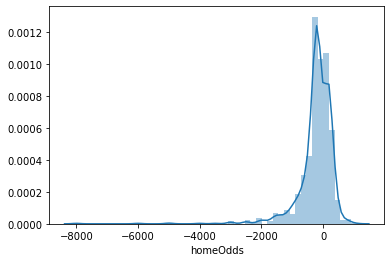

In [59]:
#Initial DBA
## home money line distribution
sns.distplot(nba_final['homeOdds'])

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


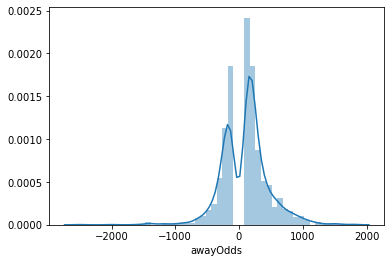

In [60]:
## away money line distribution
sns.distplot(nba_final['awayOdds'])

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


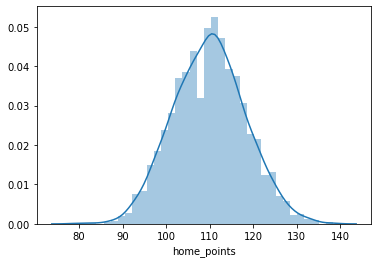

In [61]:
## points distribution
sns.distplot(nba_final['home_points'])

In [62]:
## get correlations to win
winCorr = nba_final.corr()['homeWin'].sort_values(ascending=False)

In [63]:
## top 10 correlations to home win
winCorr.head(10)

homeWin                                 1.000000
home_offensive_rating                   0.185224
home_true_shooting_percentage           0.156541
home_effective_field_goal_percentage    0.151229
home_points                             0.147727
away_losses                             0.142922
home_total_rebound_percentage           0.136997
home_wins                               0.131149
away_defensive_rating                   0.096225
home_three_point_attempt_rate           0.078068
Name: homeWin, dtype: float64

In [64]:
## bottom 10 correlations to home win
winCorr.tail(10)

away_three_point_field_goals    -0.083418
away_true_shooting_percentage   -0.084823
away_points                     -0.087323
away_offensive_rating           -0.088623
home_defensive_rating           -0.097847
home_blocks                     -0.120913
home_total_rebounds             -0.124455
home_defensive_rebounds         -0.127223
away_wins                       -0.138545
home_losses                     -0.203298
Name: homeWin, dtype: float64

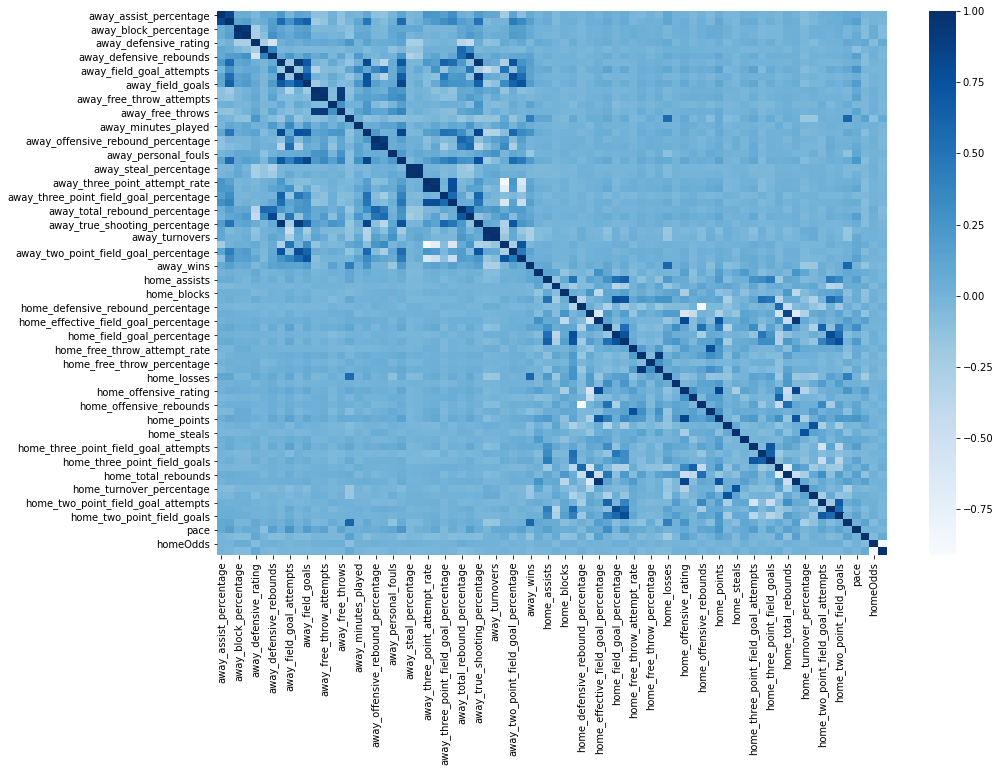

In [65]:
# Correlation heatmap
plt.subplots(figsize=(15,10))
ax = plt.axes()
corr = nba_final.corr()
sns.heatmap(corr,cmap = "Blues")

In [66]:
## list of the top 25 positive correlations
top25_corr_pos = nba_final.corr().unstack().sort_values(ascending=False).drop_duplicates()
top25_corr_pos.head(25)

awayOdds                              awayOdds                                1.000000
away_steal_percentage                 away_steals                             0.984256
away_turnovers                        away_turnover_percentage                0.966290
away_free_throw_attempts              away_free_throw_attempt_rate            0.965782
home_true_shooting_percentage         home_effective_field_goal_percentage    0.964337
away_effective_field_goal_percentage  away_true_shooting_percentage           0.962943
away_three_point_field_goal_attempts  away_three_point_attempt_rate           0.955601
away_block_percentage                 away_blocks                             0.941173
home_free_throws                      home_free_throw_attempts                0.935080
away_field_goal_percentage            away_effective_field_goal_percentage    0.935055
away_free_throw_attempts              away_free_throws                        0.929422
away_offensive_rebound_percentage     away_

In [67]:
## list of the top 25 negative correlations
top25_corr_neg = nba_final.corr().unstack().sort_values().drop_duplicates()
top25_corr_neg.head(25)

home_defensive_rebound_percentage     home_offensive_rebounds                -0.910098
away_two_point_field_goal_attempts    away_three_point_attempt_rate          -0.874806
homeOdds                              awayOdds                               -0.870390
away_two_point_field_goal_attempts    away_three_point_field_goal_attempts   -0.699835
home_total_rebound_percentage         home_total_rebounds                    -0.687128
home_defensive_rebounds               home_true_shooting_percentage          -0.635123
away_two_point_field_goals            away_three_point_attempt_rate          -0.621524
away_three_point_field_goals          away_two_point_field_goal_attempts     -0.612659
home_effective_field_goal_percentage  home_defensive_rebounds                -0.603563
home_offensive_rating                 home_defensive_rebounds                -0.588364
home_three_point_field_goal_attempts  home_two_point_field_goal_attempts     -0.548963
away_defensive_rating                 away_

In [68]:
## create list of features
excluded_from_avg = ['home_wins', 'home_losses', 'away_wins','away_losses','awayOdds','homeOdds']
features = away_cols + home_cols + excluded_from_avg

In [69]:
## declare features
x = nba_final[features]
## declare target variable
y = nba_final['homeWin']

In [70]:
x

,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,home_losses,away_wins,away_losses,awayOdds,homeOdds
77,61.933333,22.666667,5.633333,3.333333,107.733333,77.433333,37.000000,0.503000,83.333333,0.439667,36.666667,0.321000,26.333333,0.699333,18.000000,240.000000,99.366667,20.066667,9.000000,26.000000,102.000000,7.300000,7.333333,0.329667,27.666667,0.379000,10.666667,49.433333,46.000000,0.538000,17.033333,19.333333,55.666667,0.469000,26.000000,57.400000,22.333333,6.900000,4.333333,112.566667,73.966667,37.000000,0.497000,81.666667,0.480333,39.333333,0.328333,21.000000,0.735000,15.666667,240.000000,104.200000,17.433333,10.666667,21.000000,98.000000,8.766667,7.000000,0.364333,31.000000,0.402333,12.333333,44.566667,47.666667,0.529333,11.233333,15.666667,50.666667,0.545333,27.000000,1,6,0,0,115,-135
79,58.000000,20.666667,12.033333,7.333333,102.266667,77.100000,36.333333,0.535333,81.000000,0.441667,35.666667,0.274000,22.000000,0.884000,19.666667,240.000000,109.866667,20.866667,8.666667,17.666667,106.333333,7.933333,7.666667,0.577667,47.000000,0.320333,15.333333,51.033333,45.000000,0.587667,15.066667,16.000000,34.000000,0.597000,20.333333,54.766667,18.333333,11.166667,7.333333,99.066667,68.800000,34.666667,0.494667,85.666667,0.371000,31.666667,0.398667,25.333333,0.843333,21.333333,240.000000,108.466667,21.833333,15.333333,27.000000,103.333333,8.400000,8.000000,0.377333,32.333333,0.296667,9.666667,46.633333,50.000000,0.548667,13.266667,16.000000,53.333333,0.416667,22.000000,5,1,5,2,-400,300
80,58.666667,20.333333,7.533333,4.333333,96.066667,83.333333,39.000000,0.475000,83.333333,0.416333,34.666667,0.315667,26.333333,0.770667,20.000000,240.000000,100.866667,20.800000,9.666667,20.666667,99.000000,7.466667,7.333333,0.364667,30.333333,0.320667,9.666667,52.233333,48.666667,0.522333,13.333333,14.666667,53.000000,0.471000,25.000000,52.833333,16.666667,9.300000,2.666667,109.833333,78.866667,34.333333,0.552667,82.666667,0.491667,40.333333,0.199333,23.000000,0.753000,17.333333,240.000000,108.800000,16.000000,9.000000,18.333333,105.333333,8.233333,8.000000,0.383667,17.666667,0.456000,8.000000,47.366667,43.333333,0.576667,13.133333,14.333333,65.000000,0.500667,32.333333,2,3,4,2,-110,-110
85,55.066667,21.333333,4.800000,2.666667,110.400000,78.866667,33.000000,0.485333,89.33

In [71]:
y

77      False
79       True
80      False
85      False
88      False
        ...  
1225    False
1226    False
1227     True
1228     True
1229     True
Name: homeWin, Length: 2251, dtype: bool

In [72]:
## scale the features
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[ 0.37547893, -0.14285714, -0.71962617, ..., -1.07692308,
        -0.05952381,  0.05319149],
       [-0.07662835, -0.57142857,  1.07476636, ..., -0.97435897,
        -1.28571429,  0.9787234 ],
       [ 0.        , -0.64285714, -0.18691589, ..., -0.97435897,
        -0.5952381 ,  0.10638298],
       ...,
       [-1.19923372, -0.57142857, -0.79439252, ...,  2.        ,
         1.33333333, -2.        ],
       [-0.50957854, -0.35714286, -0.77570093, ...,  1.12820513,
        -0.02380952,  0.0212766 ],
       [ 0.52490421,  0.35714286, -0.77570093, ...,  1.43589744,
         0.33333333, -0.42553191]])

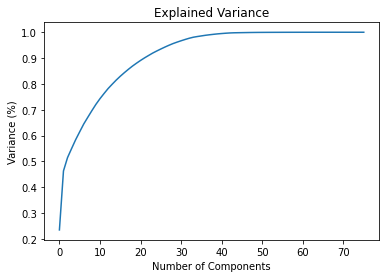

In [73]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [74]:
## create our model accuracy scorer
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

In [75]:
# Our data is continuous, so we'll use the Gaussian Classifier 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [76]:
## print score
## keep 30 components
x_pca = PCA(40).fit_transform(x_scaled)
print('Average Gaussian NB F1: {}'.format((cross_val_score(gnb, x_pca, y, scoring=scorer)).mean()))

Average Gaussian NB F1: 0.6510273839589721


In [77]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
## print score
print('Average Decision Tree F1: {}'.format((cross_val_score(clf, x_pca, y, scoring=scorer)).mean()))

Average Decision Tree F1: 0.5475533010852469


In [79]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()
## print score
print('Average Random Forest F1 score: {}'.format((cross_val_score(rfc, x_pca, y, scoring=scorer)).mean()))

Average Random Forest F1 score: 0.6325927627201992


In [80]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3)
## print score
print('Average KNN F1 score: {}'.format((cross_val_score(neighbors, x_pca, y, scoring=scorer)).mean()))

Average KNN F1 score: 0.5553087086648063


In [81]:
from sklearn.neural_network import MLPClassifier
# Establish and fit the model, with a single, 100 perceptron layer.
mlp100 = MLPClassifier(hidden_layer_sizes=(100,))
mlp1000 = MLPClassifier(hidden_layer_sizes=(1000,))

In [82]:
## print score
print('Average MLP100 F1 score: {}'.format((cross_val_score(mlp100, x_pca, y, scoring=scorer)).mean()))

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Average MLP100 F1 score: 0.6412516117595874


C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [83]:
## print score
print('Average MLP1000 F1 score: {}'.format((cross_val_score(mlp1000, x_pca, y, scoring=scorer)).mean()))

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Average MLP1000 F1 score: 0.6337280077730775


In [84]:
# declare features, scale and pca
x_test = nba_test[features]
x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled_pca = PCA(40).fit_transform(x_test_scaled)

In [85]:
# fit to training data and predict for current season
nba_test['predictions'] = gnb.fit(x_pca, y).predict(x_test_scaled_pca)

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
##Model Accuracy
## correct pct picks
len(nba_test[nba_test['predictions']==nba_test['homeWin']])/len(nba_test)


0.5627118644067797

In [87]:
## create an empty money won column
nba_test['moneyWon'] = 0

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
## calculate money won
for i in nba_test.index:
  ## check for correct pick
  if nba_test['predictions'].iloc[i] == nba_test['homeWin'].iloc[i]:
    ## correct home win
    if nba_test['homeWin'].iloc[i] == True:
      ## home is favored
      if nba_test['homeOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['homeOdds'].iloc[i]))/100))
      ## home is underdog
      elif nba_test['homeOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['homeOdds'].iloc[i])/100))
      ## even odds
      elif nba_test['homeOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100
    ## correct away win
    if nba_test['homeWin'].iloc[i] == False:
      ## away is favored
      if nba_test['awayOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['awayOdds'].iloc[i]))/100))
      ## away is underdog
      elif nba_test['awayOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['awayOdds'].iloc[i])/100))
      ## even odds
      elif nba_test['awayOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100
  ## incorrect pick
  elif nba_test['predictions'].iloc[i] != nba_test['homeWin'].iloc[i]:
    nba_test.at[i, 'moneyWon'] = -100

In [89]:
## create cumulative money won column
nba_test['cumTotalWon']  = nba_test['moneyWon'].cumsum()

C:\Users\Admin\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
# check work
nba_test[['predictions','homeWin','homeOdds','awayOdds','moneyWon','cumTotalWon']].head(10)

,predictions,homeWin,homeOdds,awayOdds,moneyWon,cumTotalWon
0,True,False,150,-180,-100,-100
1,True,False,-260,210,-100,-200
2,True,True,-105,-115,95,-105
3,False,True,-180,150,-100,-205
4,True,True,-170,145,58,-147
5,True,False,260,-330,-100,-247
6,True,True,-110,-110,90,-157
7,True,False,-165,142,-100,-257
8,True,True,-150,130,66,-191
9,True,True,-350,275,28,-163


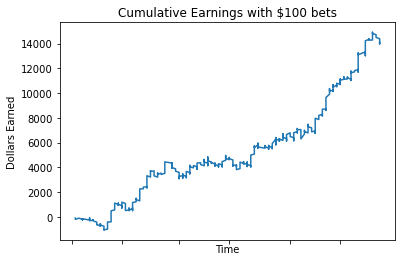

In [91]:
## plot the cumulative money won over time
fig, ax = plt.subplots()
plt.plot(nba_test['date'], nba_test['cumTotalWon'])
plt.title('Cumulative Earnings with $100 bets')
plt.ylabel('Dollars Earned')
plt.xlabel('Time')
ax.tick_params(labelbottom=False)

In [92]:
print("The model's low point is {} dollars.".format(nba_test['cumTotalWon'].min()))
print("The model's high point is {} dollars.".format(nba_test['cumTotalWon'].max()))
print("The model has profited {} dollars this season.".format(nba_test['cumTotalWon'].iloc[-1]))

The model's low point is -1054 dollars.
The model's high point is 14916 dollars.
The model has profited 14106 dollars this season.


In [93]:
## top 5 wins
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 100].sort_values(by='moneyWon',ascending=False).head()

,date,homeTeam,awayTeam,predictions,homeWin,homeOdds,awayOdds,moneyWon
540,2020-01-20,CLE,NYK,False,False,-2500,1100,1100
459,2020-01-08,UTA,NYK,True,True,850,-1500,850
329,2019-12-21,DET,CHI,False,False,-1100,700,700
479,2020-01-11,OKC,LAL,False,False,-1000,650,650
413,2020-01-02,SAS,OKC,False,False,-1000,650,650


In [94]:
## least money made on a bet
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 0].sort_values(by='moneyWon').head()

,date,homeTeam,awayTeam,predictions,homeWin,homeOdds,awayOdds,moneyWon
120,2019-11-22,UTA,GSW,True,True,-3500,1300,2
194,2019-12-02,PHI,UTA,True,True,-3000,1200,3
179,2019-11-30,PHI,IND,True,True,-1500,850,6
458,2020-01-08,ORL,WAS,True,True,-1500,850,6
499,2020-01-14,MEM,HOU,True,True,-1600,912,6
